# Peter For cold start

#### Why Peter model is important?

Optimizing a large pretrained network and fitting it to downstream tasks is an effective approach to such problems. However, fine-tuning usually requires retraining the entire network and optimizing a large number of model parameters, so fine-tuning is very inefficient from the perspective of parameter volume. To overcome this problem, the researchers developed a parameter-efficient transfer learning architecture "PeterRec".

#### Architecture

the pre-training network uses a dilated convolutional network, and the dilated factor of each layer is increased by 2^n. By superimposing dilated convolutional layers, the visual field can be increased exponentially. This design mainly follows the timing model NextItNet. In terms of pre-training optimization methods, it adopts two self-supervised methods, one-way autoregressive method and two-way masking method, which correspond to causal convolution and non-causal convolutional networks.

#### Metrics

NDCG (Normalized Discounted Cumulative Gain) is a popular evaluation metric used to assess the performance of ranking algorithms in information retrieval and recommendation systems. It measures the quality of the ranked results by comparing the predicted ranking to the ground truth (ideal) ranking of items.

Cross-Entropy Loss:
When dealing with classification tasks, we often use the cross-entropy loss as the objective function for training the model. The cross-entropy loss between the true labels (ground truth) and the predicted probabilities 

The train_time and val_time are the sum of the individual epoch times.

#### Note: 

While the ideal implementation involves increasing the number of epochs to allow the model more time to learn from the data and converge better, our current hardware limitations, such as insufficient storage and low RAM, make it challenging to run the model with an extensive training schedule. As a result, we have to reduce the number of epochs to accommodate the available resources. This might impact the model's performance to some extent.

### Importing libraries

In [ ]:
# imports 
import pandas as pd
import os
import argparse
import numpy as np

from peter4pytorch import Peter4Coldstart
from  preprocesing import *
from  train import *

In [2]:
def set_seed(seed, re=True):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    if re:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False

**--seed**: Integer argument,  Used for setting the random seed for reproducibility.

**--task_name**: String argument, default value is 'cold_start'. 

**--task_num**: Integer argument,  Specifies the task number.

**--source_path**: String argument. Specifies the path to the source data file.

**--target_path**: String argument. Specifies the path to the target data file.

**--train_batch_size**: Integer argument Specifies the batch size for training.

**--val_batch_size**: Integer argument Specifies the batch size for validation.

**--test_batch_size**: Integer argument Specifies the batch size for testing.

**--sample**: String argument, Specifies the sampling method.

**--max_len**: Integer argument, Specifies the maximum length of the input sequence.

**--item_min**: Integer argument, Specifies the minimum number of items.

**--save_path**: String argument,Specifies the path for saving the model checkpoints.

**--task**: Integer argument. Specifies the task to perform.

**--valid_rate**: Integer argument. Specifies the validation rate.

**--is_pretrain**: Integer argument Specifies the type of transfer learning (0: mean transfer, 1: mean pretrain, 2: mean train full model without transfer).

**--model_name**: String argument Specifies the name of the model.

**--epochs**: Integer argument Specifies the number of training epochs.

**--lr**: Float argument Specifies the learning rate.

**--device**: String argumentSpecifies the device to be used for training ('cuda' for GPU, 'cpu' for CPU).

**--is_parallel**: Boolean argument, Specifies whether to use parallel processing (distributed training).

**--weight_decay**: Float argument,  Specifies the weight decay (L2 regularization) for optimization.

**--decay_step**: Integer argument Specifies the decay step for StepLR scheduler.

**--gamma**: Float argument Specifies the gamma value for StepLR scheduler.

**--num_items**: Integer argument, Specifies the number of total items.

**--target_num**: Integer argument, Specifies the number of total target items for each user.

**--num_embedding**: Integer argument, Specifies the number of total source items.

**--k**: Integer argument, default value is 20. Specifies the number of items to measure the hit@k metric
**--metric_ks**: List of integers Specifies the k values for Metric@k.

**--best_metric**: String argument, Specifies the metric used to determine the best model.

**--hidden_size**: Integer argument,Specifies the size of hidden vectors (model).

**--block_num**: Integer argument, Specifies the number of transformer layers.

**--num_groups**: Integer argument, Specifies the number of transformer groups.

**--num_heads**: Integer argument. Specifies the number of heads for multi-attention.

**--dropout**: Float argument, Specifies the dropout probability to use throughout the model.

**--bert_mask_prob**: Float argument, Specifies the probability for masking items in the training sequence.

**--factor_num**: Integer argument, Specifies a factor number.

**--embedding_size**: Integer argument Specifies the embedding size for the model.

**--dilations**: Integer argument, Specifies the dilations for the model.

**--kernel_size**: Integer argument ,Specifies the kernel size for the model.

**--is_mp**: Boolean argument, default value is False. Specifies whether to use mean pooling.

**--pad_token**: Integer argument Specifies the padding token.

**--temp**: Integer argument, Specifies a temperature value.

In [7]:
parser = argparse.ArgumentParser()

parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--task_name', default='cold_start')
parser.add_argument('--task_num', type=int, default=4)
# parser.add_argument('--dataset_path', type=str, default='Tenrec/cold_data.csv')
# parser.add_argument('--pretrain_path', type=str, default='')
parser.add_argument('--source_path', type=str, default='Tenrec/cold_data_0.3.csv')
parser.add_argument('--target_path', type=str, default='Tenrec/cold_data.csv')
parser.add_argument('--train_batch_size', type=int, default=512)
parser.add_argument('--val_batch_size', type=int, default=512)
parser.add_argument('--test_batch_size', type=int, default=512)
parser.add_argument('--sample', type=str, default='random')

parser.add_argument('--max_len', type=int, default=30)
parser.add_argument('--item_min', type=int, default=20)
parser.add_argument('--save_path', type=str, default='./checkpoint/')
parser.add_argument('--task', type=int, default=-1)
parser.add_argument('--valid_rate', type=int, default=100)


#transfer learning
parser.add_argument('--is_pretrain', type=int, default=1, help='0: mean transfer, 1: mean pretrain, 2:mean train full model without transfer')

parser.add_argument('--model_name', default='Peter4Coldstart')

parser.add_argument('--epochs', type=int, default=3)

parser.add_argument('--lr', type=float, default=0.001)

parser.add_argument('--device', default='cuda')  # cuda:0
parser.add_argument('--is_parallel', type=bool, default=False)
parser.add_argument('--weight_decay', type=float, default=0.0, help='l2 regularization') 
parser.add_argument('--decay_step', type=int, default=5, help='Decay step for StepLR')
parser.add_argument('--gamma', type=float, default=0.6, help='Gamma for StepLR')
parser.add_argument('--num_items', type=int, default=1, help='Number of total items')
parser.add_argument('--target_num', type=int, default=1, help='Number of total target items for each user')

parser.add_argument('--num_embedding', type=int, default=1, help='Number of total source items')
parser.add_argument('--k', type=int, default=20, help='The number of items to measure the hit@k metric (i.e. hit@10 to see if the correct item is within the top 10 scores)')
parser.add_argument('--metric_ks', nargs='+', type=int, default=[5, 20], help='ks for Metric@k')
parser.add_argument('--best_metric', type=str, default='NDCG@10', help='Metric for determining the best model')

#model param
parser.add_argument('--hidden_size', type=int, default=128, help='Size of hidden vectors (model)')
parser.add_argument('--block_num', type=int, default=2, help='Number of transformer layers')
parser.add_argument('--num_groups', type=int, default=2, help='Number of transformer groups')
parser.add_argument('--num_heads', type=int, default=2, help='Number of heads for multi-attention')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout probability to use throughout the model')
parser.add_argument('--bert_mask_prob', type=float, default=0.5,
                    help='Probability for masking items in the training sequence')
parser.add_argument('--factor_num', type=int, default=64)


#Nextitnet
parser.add_argument('--embedding_size', type=int, default=256, help='embedding_size for model')
parser.add_argument('--dilations', type=int, default=[1, 4], help='Number of transformer layers')
parser.add_argument('--kernel_size', type=int, default=5, help='Number of heads for multi-attention')
parser.add_argument('--is_mp', type=bool, default=False, help='Number of heads for multi-attention')
parser.add_argument('--pad_token', type=int, default=0)
parser.add_argument('--temp', type=int, default=10)

# cold_start


args = parser.parse_args("")

if args.is_parallel:
        torch.distributed.init_process_group(backend="nccl")
        torch.cuda.set_device(args.local_rank)
device = torch.device(args.device)
# if 'bert' in args.model_name:
set_seed(args.seed)
writer = SummaryWriter()
print(args)
    


Namespace(seed=0, task_name='cold_start', task_num=4, source_path='Tenrec/cold_data_0.3.csv', target_path='Tenrec/cold_data.csv', train_batch_size=512, val_batch_size=512, test_batch_size=512, sample='random', max_len=30, item_min=20, save_path='./checkpoint/', task=-1, valid_rate=100, is_pretrain=1, model_name='Peter4Coldstart', epochs=3, lr=0.001, device='cuda', is_parallel=False, weight_decay=0.0, decay_step=5, gamma=0.6, num_items=1, target_num=1, num_embedding=1, k=20, metric_ks=[5, 20], best_metric='NDCG@10', hidden_size=128, block_num=2, num_groups=2, num_heads=2, dropout=0.5, bert_mask_prob=0.5, factor_num=64, embedding_size=256, dilations=[1, 4], kernel_size=5, is_mp=False, pad_token=0, temp=10)


# First way of pre processing  


### **1) By using first preprocessing**, two datasets is used 

the target datafile cold_data.csv

the source datafile sbr_data_1M.csv 

model: Peter4Coldstart 

train_loader: Data loaders are used to efficiently load and preprocess data during the training process.

val_loader:Data loader for the validation dataset. Validation data is used to evaluate the model's performance during training and prevent overfitting.

writer: logging utility used to write and store training information, such as loss values, accuracy metrics

args: This is possibly a dictionary or a set of arguments that configures the training process, such as learning rate, number of epocs

The train() function, which is not provided in the snippet, would typically include the training loop. It would iterate over the training data, update the model's weights based on the loss function and optimizer, and periodically evaluate the model on the validation data. The purpose of this function is to train the model and optimize its parameters so that it performs well on unseen data.


In [17]:
# Define the paths to the target and source data files
args.target_path = 'Tenrec/cold_data.csv' 


# Define the paths to the target and source data files
args.source_path = 'Tenrec/sbr_data_1M.csv' 


train_loader, val_loader, test_loader = process_data(args)

model =Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.301681633834
one epoch train time: 71.33592438697815
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0002, device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 105.01313185691833
one epoch train time: 176.35329055786133
Training CE Loss: 9.309384744245927
one epoch train time: 66.58933854103088
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0001, device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 108.42712378501892
one epoch train time: 175.02098560333252
Training CE Loss: 9.005943078261156
one epoch train time: 66.5638062953949
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0002, dev

Peter4Coldstart(
  (item_embedding): Embedding(934664, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_siz

### **Observation**
By increasing the epochs the Cross entropy loss decrease . This behavior is generally expected and is a sign of the model's learning progress.

**Results**

Training CE Loss: 7.624275453798064


### **2) By using first preprocessing**, two datasets is used 

the target datafile cold_data_1.csv

the source datafile sbr_data_1M.csv 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.2851637580178
one epoch train time: 44.350229024887085
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0004, device='cuda:0') 0
Train/NDCG@5 tensor(0.0003, device='cuda:0') 0
one epoch val time: 49.197405099868774
one epoch train time: 93.55375528335571
Training CE Loss: 9.31161816336892
one epoch train time: 38.99527049064636
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0009, device='cuda:0') 1
Train/NDCG@5 tensor(0.0004, device='cuda:0') 1
one epoch val time: 48.992340087890625
one epoch train time: 87.99238419532776
Training CE Loss: 9.095337538285689
one epoch train time: 38.97987174987793
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0

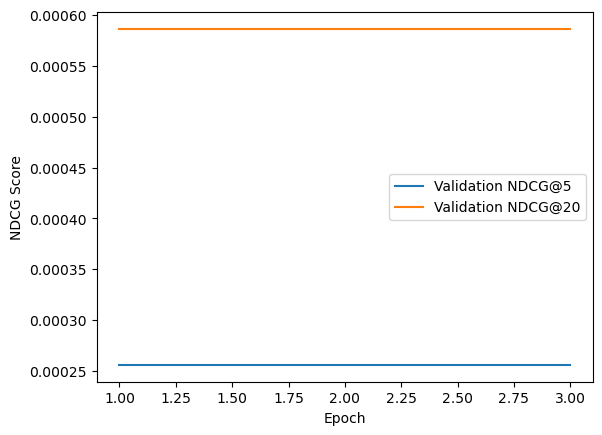

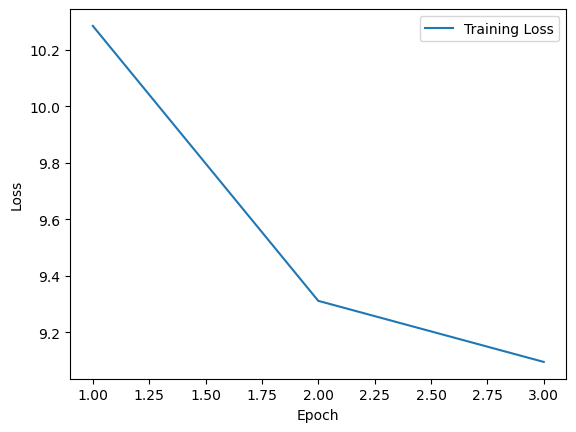

Peter4Coldstart(
  (item_embedding): Embedding(934664, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_siz

In [16]:
args.target_path = 'Tenrec/cold_data_1.csv' 


# Define the paths to the target and source data files
args.source_path = 'Tenrec/sbr_data_1M.csv' 

train_loader, val_loader, test_loader = process_data(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### **Observation**

**Results**

Training CE Loss: 9.095337538285689

A large cross-entropy loss indicates that the predicted probabilities are significantly different from the true probabilities. This suggests that the model is struggling to make accurate predictions and is not effectively learning the patterns in the data. so another Preprocessing is required to get the best result

## **Trial 2**

### **1) By using Second preprocessing**, two datasets is used 

It will be same as the first way but we will filter items using **like column**

the target datafile cold_data.csv

the source datafile sbr_data_1M.csv 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 5.277176380157471
one epoch train time: 5.697686672210693
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 0.08134603500366211
one epoch train time: 5.783593654632568
Training CE Loss: 4.391632080078125
one epoch train time: 0.07541108131408691
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 0.010393619537353516
one epoch train time: 0.08998727798461914
Training CE Loss: 3.8360400199890137
one epoch train time: 0.0726766586303711
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0., devic

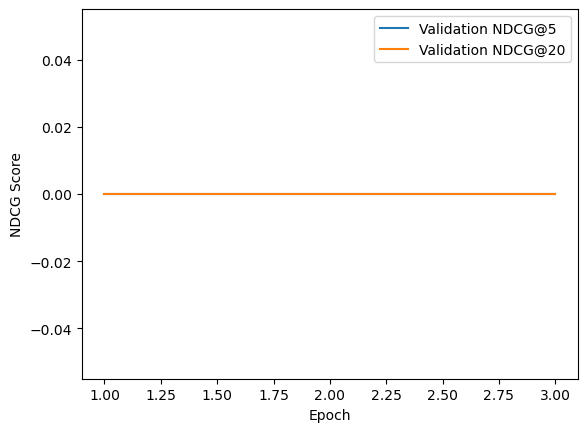

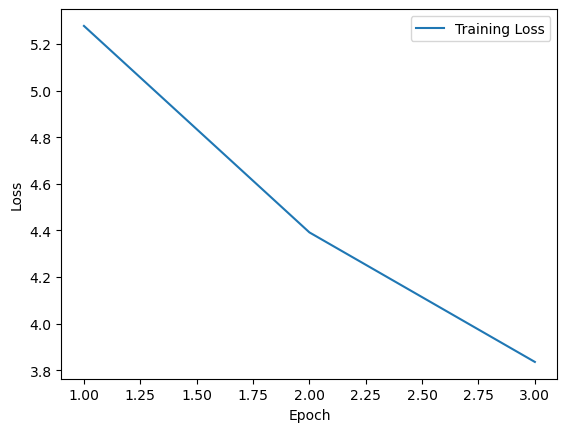

Peter4Coldstart(
  (item_embedding): Embedding(68960, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [15]:

# Define the paths to the target and source data files
args.target_path = 'Tenrec/cold_data.csv' 
args.source_path = 'Tenrec/sbr_data_1M.csv' 

train_loader, val_loader, test_loader = process_dataV2(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
Results

Training CE Loss: 3.8360400199890137

A significant development in CE loss

When the cross-entropy loss is small, it means that the model has learned to effectively distinguish between different classes and has a good understanding of the underlying patterns in the data. 

### **2) By using Second preprocessing**, two datasets is used 

the target datafile cold_data_1.csv

the source datafile sbr_data_1M.csv 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 4.617593288421631
one epoch train time: 0.05042433738708496
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 0.01102590560913086
one epoch train time: 0.0670013427734375
Training CE Loss: 3.355496644973755
one epoch train time: 0.0454866886138916
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 0.009441852569580078
one epoch train time: 0.05932903289794922
Training CE Loss: 3.038039207458496
one epoch train time: 0.043651580810546875
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0., de

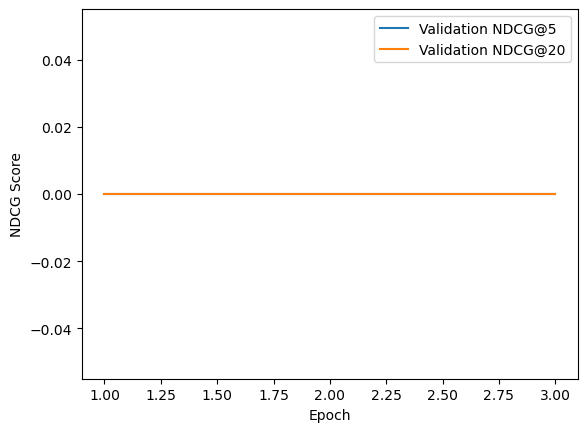

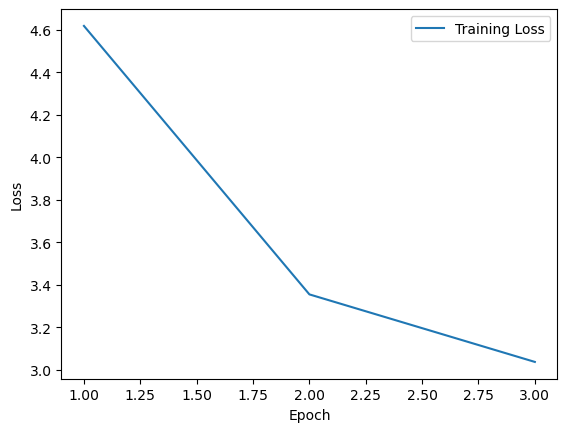

Peter4Coldstart(
  (item_embedding): Embedding(68960, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [16]:
args.target_path = 'Tenrec/cold_data_1.csv' 


# Define the paths to the target and source data files
args.source_path = 'Tenrec/sbr_data_1M.csv' 

train_loader, val_loader, test_loader = process_dataV2(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
Results

**Training CE Loss: 3.038039207458496**

this continuous reduction in cross-entropy signifies that the model is making strides towards achieving its primary objective of accurate and precise predictions, ultimately leading to enhanced performance on unseen data.

## This is the best Result so far

### **3) By using Second preprocessing**, two datasets is used 

the target datafile cold_data_0.3.csv

the source datafile sbr_data_1M.csv 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 7.282928943634033
one epoch train time: 0.6884217262268066
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 0.010027170181274414
one epoch train time: 0.7030231952667236
Training CE Loss: 6.141390800476074
one epoch train time: 0.6613433361053467
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 0.009308815002441406
one epoch train time: 0.6757481098175049
Training CE Loss: 5.663766384124756
one epoch train time: 0.662949800491333
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device

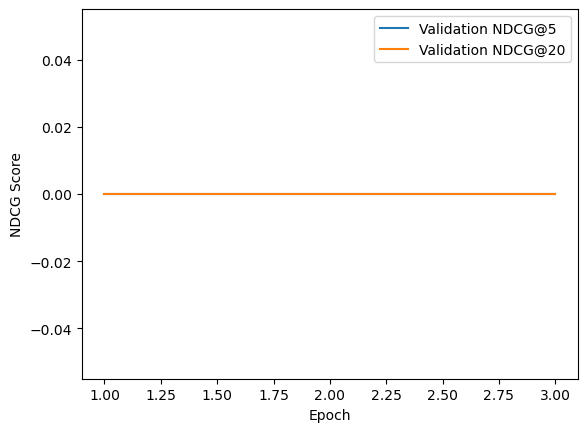

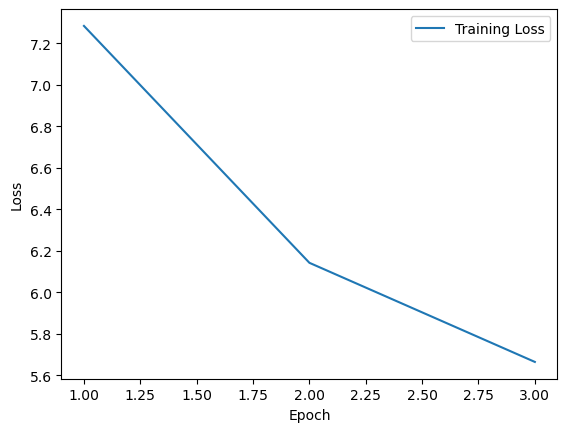

Peter4Coldstart(
  (item_embedding): Embedding(68960, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [17]:

# Define the paths to the target and source data files
args.target_path = 'Tenrec/cold_data_0.3.csv' 
args.source_path = 'Tenrec/sbr_data_1M.csv' 

train_loader, val_loader, test_loader = process_dataV2(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
By increasing the epochs the Cross entropy loss decrease

Results

Training CE Loss: 5.663766384124756

### **4) By using Second preprocessing**, two datasets is used 

the target datafile cold_data_0.7.csv

the source datafile sbr_data_1M.csv 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 6.157742500305176
one epoch train time: 0.28348374366760254
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0625, device='cuda:0') 0
Train/NDCG@5 tensor(0.0625, device='cuda:0') 0
one epoch val time: 0.01795816421508789
one epoch train time: 0.30771970748901367
Training CE Loss: 5.800783634185791
one epoch train time: 0.2804248332977295
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 0.012316226959228516
one epoch train time: 0.29283571243286133
Training CE Loss: 5.495081901550293
one epoch train time: 0.2804083824157715
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor

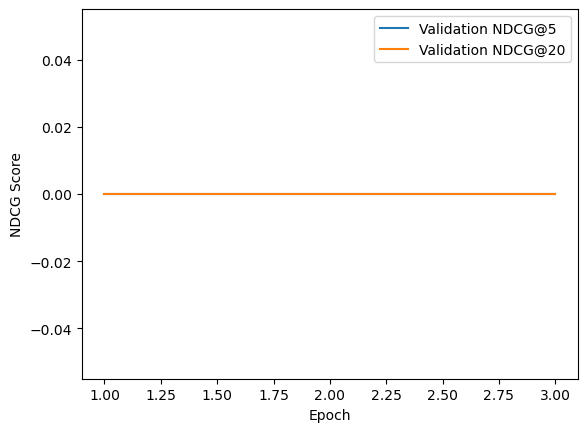

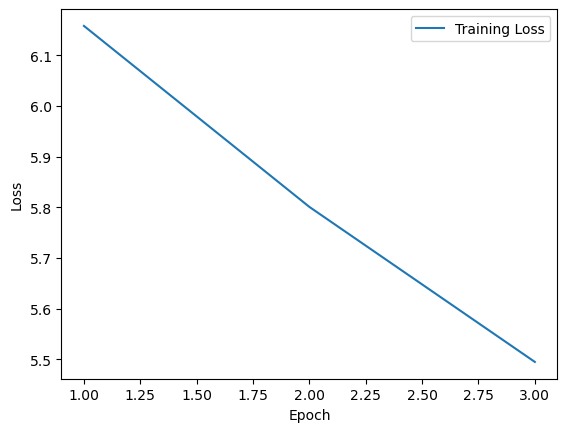

Peter4Coldstart(
  (item_embedding): Embedding(68960, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [18]:

# Define the paths to the target and source data files
args.target_path = 'Tenrec/cold_data_0.7.csv' 
args.source_path = 'Tenrec/sbr_data_1M.csv' 

train_loader, val_loader, test_loader = process_dataV2(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
Results

Training CE Loss: 5.495081901550293

there is a slight increase here in CE loss this dataset

A value of 0 for both NDCG@20 and NDCG@5 typically indicates that the model's ranking is not consistent with the ground truth rankings in the training data.

## **Trial 3**

### **1) By using Third way of preprocessing**, one dataset is used 

the source datafile cold_data.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.392641614465152
one epoch train time: 51.81202816963196
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0006, device='cuda:0') 0
Train/NDCG@5 tensor(0.0005, device='cuda:0') 0
one epoch val time: 72.62103152275085
one epoch train time: 124.43731379508972
Training CE Loss: 9.361356033998376
one epoch train time: 46.29078674316406
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0004, device='cuda:0') 1
Train/NDCG@5 tensor(0.0002, device='cuda:0') 1
one epoch val time: 72.2917275428772
one epoch train time: 118.58263063430786
Training CE Loss: 9.06604576812071
one epoch train time: 46.213218688964844
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0.

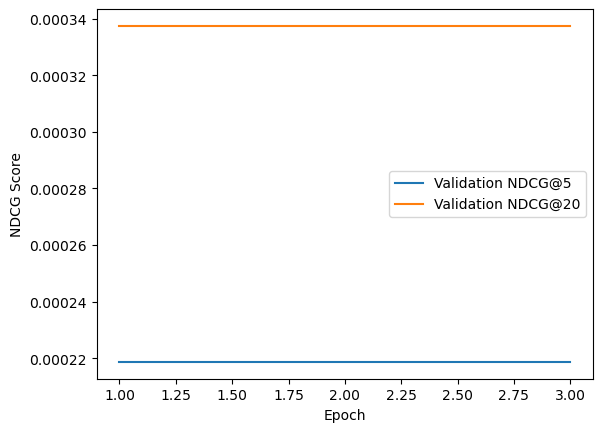

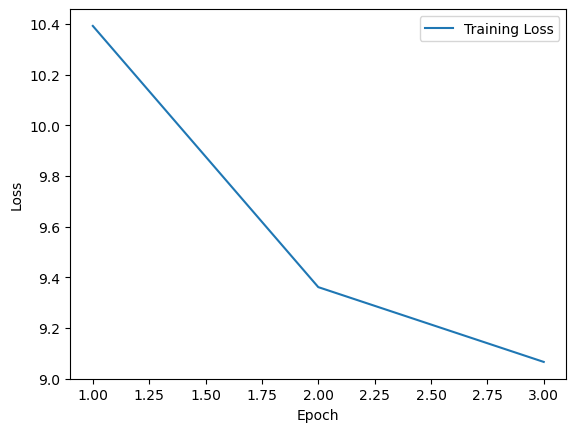

Peter4Coldstart(
  (item_embedding): Embedding(55747, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [16]:
# Define the paths to the target and source data files
args.source_path = 'Tenrec/cold_data.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV3(args,2)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 

Results
 
Training CE Loss: 9.06604576812071

A significant increase again to CE loss here

A low NDCG score could be because of Insufficient Training: The model may not have been trained for enough epochs.

### **2) By using Third way of preprocessing**, one dataset is used 

the source datafile cold_data_1.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.402635680304634
one epoch train time: 36.791396617889404
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0007, device='cuda:0') 0
Train/NDCG@5 tensor(0.0005, device='cuda:0') 0
one epoch val time: 52.733020067214966
one epoch train time: 89.52925038337708
Training CE Loss: 9.418061680263943
one epoch train time: 36.769147872924805
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0006, device='cuda:0') 1
Train/NDCG@5 tensor(0.0003, device='cuda:0') 1
one epoch val time: 50.7652952671051
one epoch train time: 87.53451752662659
Training CE Loss: 9.23127031326294
one epoch train time: 36.76720690727234
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0.

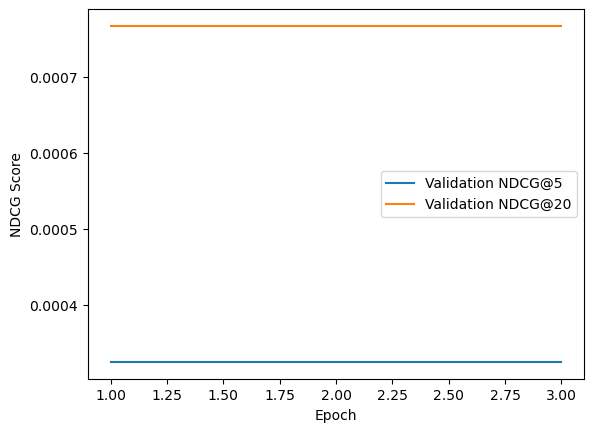

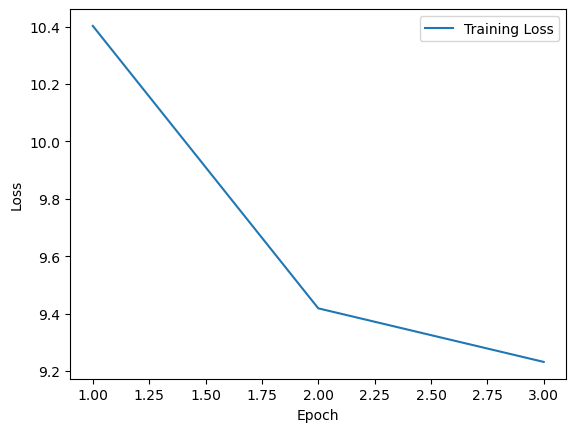

Peter4Coldstart(
  (item_embedding): Embedding(42978, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [17]:
args.source_path = 'Tenrec/cold_data_1.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV3(args,2)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 

Results

Training CE Loss:

Epoch 1: 10.402635680304634

Epoch 2: 9.418061680263943

Epoch 3: 9.23127031326294
NDCG@20 and NDCG@5 Evaluation on the Training Dataset:

Epoch 1: NDCG@20 = 0.0007, NDCG@5 = 0.0005

Epoch 2: NDCG@20 = 0.0006, NDCG@5 = 0.0003

Epoch 3: NDCG@20 = 0.0008, NDCG@5 = 0.0003

Training Time and Validation Time :

Epoch 1: Training time = 36.791396617889404, Validation time = 52.733020067214966

Epoch 2: Training time = 36.769147872924805, Validation time = 50.7652952671051

Epoch 3: Training time = 36.76720690727234, Validation time = 51.152446031570435

 Cross-Entropy loss is decreasing as the training progresses, which is a positive sign. However, the NDCG@20 and NDCG@5 values are quite low, close to zero, for all epochs. 



### **3) By using Third way of preprocessing**, one dataset is used 

the source datafile cold_data_0.3.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.29908954446966
one epoch train time: 76.40225410461426
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 17.009028434753418
one epoch train time: 93.41561818122864
Training CE Loss: 9.39716155312278
one epoch train time: 76.45184230804443
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 16.971836805343628
one epoch train time: 93.4282796382904
Training CE Loss: 9.044636405598034
one epoch train time: 76.68933916091919
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0')

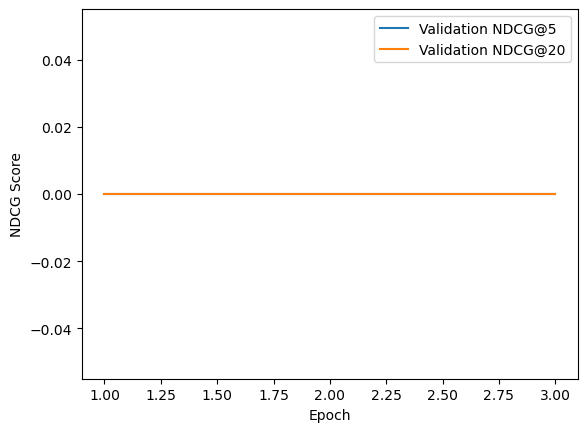

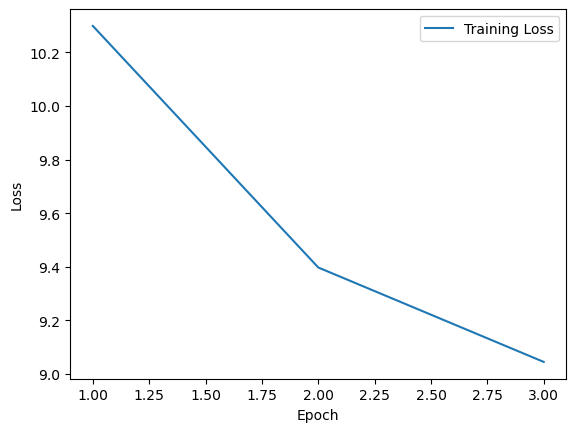

Peter4Coldstart(
  (item_embedding): Embedding(121860, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_siz

In [18]:
# Define the paths to the target and source data files
args.source_path = 'Tenrec/cold_data_0.3.csv' 
args.item_min = 2
args.target_num = 1


train_loader, val_loader, test_loader = process_dataV3(args,2)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 

By increasing the epochs the Cross entropy loss decrease

Results

Training CE Loss:

Epoch 1: 10.29908954446966

Epoch 2: 9.39716155312278

Epoch 3: 9.044636405598034

NDCG@20 and NDCG@5 Evaluation on the Training Dataset:

Training Time and Validation Time:

Epoch 1: Training time = 76.40225410461426, Validation time = 17.009028434753418

Epoch 2: Training time = 76.45184230804443, Validation time = 16.971836805343628

Epoch 3: Training time = 76.68933916091919, Validation time = 16.979027271270752

it appears that the Cross-Entropy loss is decreasing during the training process, which is a positive sign, as it means the model is learning from the data.

### **4) By using Third way of preprocessing**, one dataset is used 

the source datafile cold_data_0.7.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.408460776011148
one epoch train time: 53.623677253723145
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0004, device='cuda:0') 0
Train/NDCG@5 tensor(0.0003, device='cuda:0') 0
one epoch val time: 36.99032187461853
one epoch train time: 90.61858940124512
Training CE Loss: 9.392331355657333
one epoch train time: 53.59814214706421
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0005, device='cuda:0') 1
Train/NDCG@5 tensor(0.0004, device='cuda:0') 1
one epoch val time: 36.99250030517578
one epoch train time: 90.59520268440247
Training CE Loss: 9.095316434517885
one epoch train time: 53.63621950149536
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0.

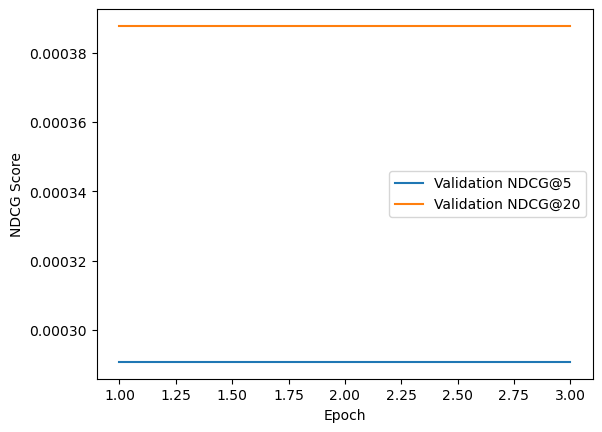

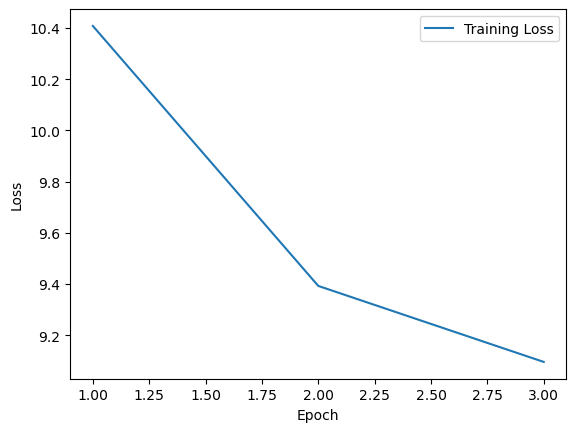

Peter4Coldstart(
  (item_embedding): Embedding(95696, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [19]:

# Define the paths to the target and source data files
args.source_path = 'Tenrec/cold_data_0.7.csv' 
args.item_min = 2
args.target_num = 1


train_loader, val_loader, test_loader = process_dataV3(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
Epoch 1: 10.408460776011148

Epoch 2: 9.392331355657333

Epoch 3: 9.095316434517885

NDCG@20 and NDCG@5 Evaluation on the Training Dataset:

Epoch 1: NDCG@20 = 0.0004, NDCG@5 = 0.0003

Epoch 2: NDCG@20 = 0.0005, NDCG@5 = 0.0004

Epoch 3: NDCG@20 = 0.0004, NDCG@5 = 0.0003

Training Time and Validation Time :

Epoch 1: Training time = 53.623677253723145, Validation time = 36.99032187461853

Epoch 2: Training time = 53.59814214706421, Validation time = 36.99250030517578

Epoch 3: Training time = 53.63621950149536, Validation time = 37.32464838027954

One noteworthy point is that the validation time remains relatively stable across epochs, with only minor variation the validation dataset's size or complexity might not be significantly impacting the model's evaluation time.

## **Trial 4**

### **1) By using fouth way of preprocessing**, one dataset is used 

here we will use only one dataset to extract both target and source we will take from user sequence the target output

the source datafile cold_data.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.371864164576811
one epoch train time: 46.551026582717896
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(6.0998e-05, device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 71.67929863929749
one epoch train time: 118.23507356643677
Training CE Loss: 9.379177682539996
one epoch train time: 46.50325560569763
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0002, device='cuda:0') 1
Train/NDCG@5 tensor(0.0001, device='cuda:0') 1
one epoch val time: 70.6132459640503
one epoch train time: 117.12106513977051
Training CE Loss: 9.092166402760673
one epoch train time: 46.536399126052856
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(

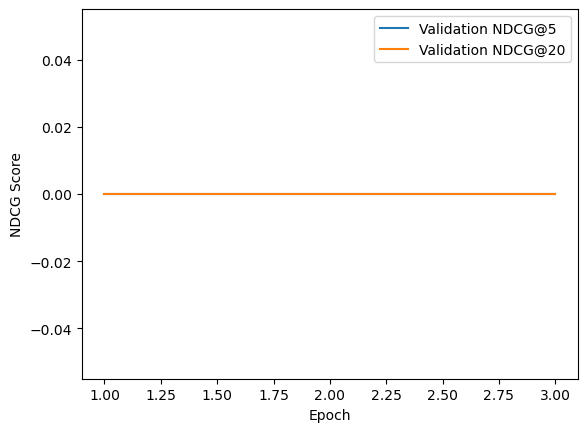

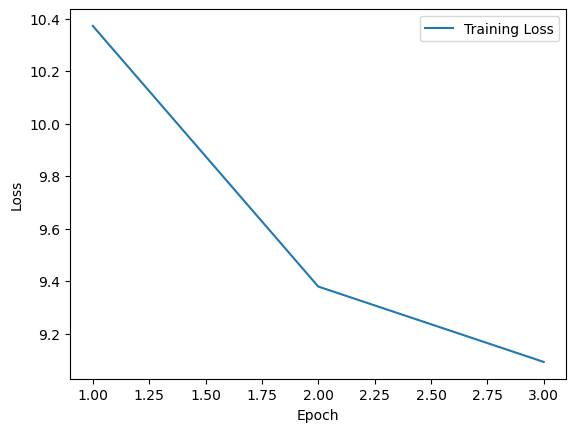

Peter4Coldstart(
  (item_embedding): Embedding(55747, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [21]:

# Define the paths to the target and source data files
args.source_path = 'Tenrec/cold_data.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV4(args,2)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
By increasing the epochs the Cross entropy loss decrease

Results

Training CE Loss: 9.092166402760673

### **2) By using fouth way of preprocessing**, one dataset is used 

here we will use only one dataset to extract both target and source we will take from user sequence the target output

the source datafile cold_data_1.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.376852088504368
one epoch train time: 36.756245136260986
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0006, device='cuda:0') 0
Train/NDCG@5 tensor(0.0004, device='cuda:0') 0
one epoch val time: 50.874999046325684
one epoch train time: 87.63671851158142
Training CE Loss: 9.46076809918439
one epoch train time: 36.749715089797974
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0004, device='cuda:0') 1
Train/NDCG@5 tensor(0.0003, device='cuda:0') 1
one epoch val time: 50.509570598602295
one epoch train time: 87.25936818122864
Training CE Loss: 9.362244500054253
one epoch train time: 36.71601891517639
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(

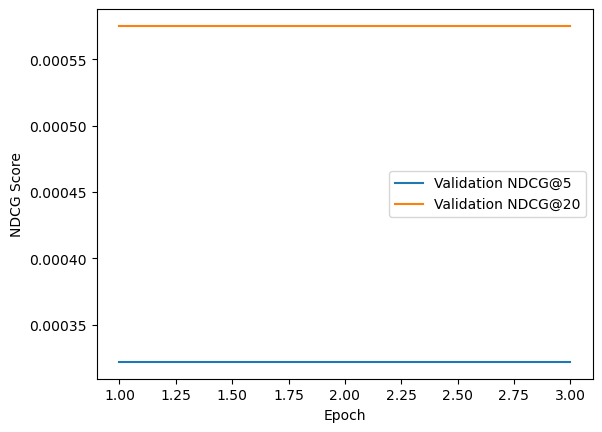

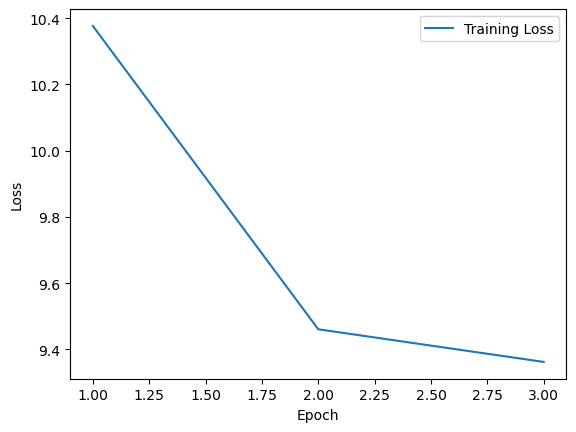

Peter4Coldstart(
  (item_embedding): Embedding(42978, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [22]:
args.source_path = 'Tenrec/cold_data_1.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV4(args,2)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 

Results

Training CE Loss: 9.362244500054253

Training Time: The training time for each epoch appears consistent, with a duration of approximately 36 to 37 min.

Validation Time: The validation time for each epoch also remains relatively stable, with a duration of approximately 50 to 52 min.

Having stable training and validation times is advantageous as it allows you to have better predictability in terms of the overall training process. 

### **3) By using fouth way of preprocessing**, one dataset is used 

here we will use only one dataset to extract both target and source we will take from user sequence the target output

the source datafile cold_data_0.3.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.331544442610307
one epoch train time: 76.3157205581665
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 0
Train/NDCG@5 tensor(0., device='cuda:0') 0
one epoch val time: 16.7398099899292
one epoch train time: 93.0597243309021
Training CE Loss: 9.397409152984618
one epoch train time: 76.09964323043823
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 1
Train/NDCG@5 tensor(0., device='cuda:0') 1
one epoch val time: 16.708166360855103
one epoch train time: 92.81214809417725
Training CE Loss: 9.078854950991543
one epoch train time: 76.21591329574585
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0., device='cuda:0') 

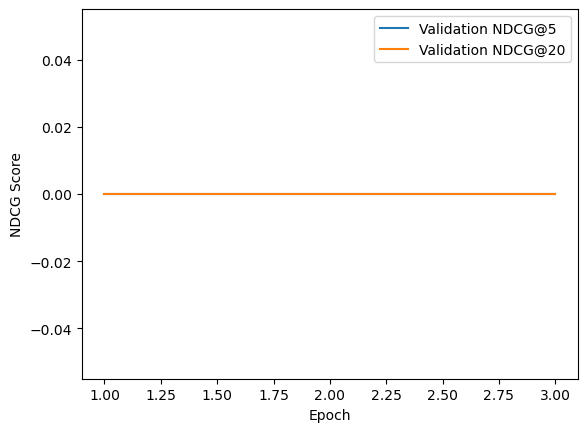

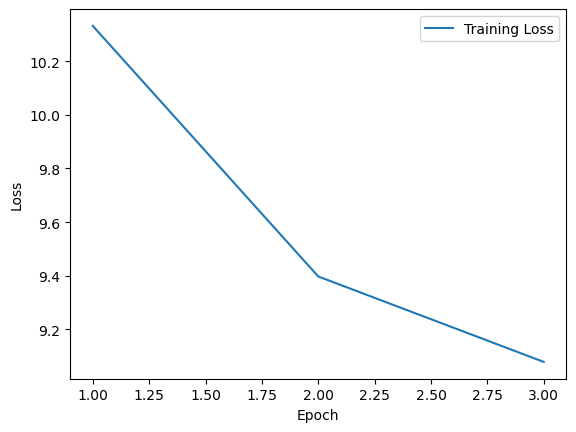

Peter4Coldstart(
  (item_embedding): Embedding(121860, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_siz

In [23]:
# Define the paths to the target and source data files
args.source_path = 'Tenrec/cold_data_0.3.csv' 
args.item_min = 2
args.target_num = 1


train_loader, val_loader, test_loader = process_dataV4(args,2)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
Results

Training CE Loss:9.078854950991543

the CE slightly decreases  from the previous run

### **4) By using fouth way of preprocessing**, one dataset is used 

here we will use only one dataset to extract both target and source we will take from user sequence the target output

the source datafile cold_data_0.7.csv

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 10.373276734963442
one epoch train time: 53.54928421974182
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0009, device='cuda:0') 0
Train/NDCG@5 tensor(0.0006, device='cuda:0') 0
one epoch val time: 36.44639205932617
one epoch train time: 90.0005133152008
Training CE Loss: 9.409154989780523
one epoch train time: 53.50351071357727
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0013, device='cuda:0') 1
Train/NDCG@5 tensor(0.0010, device='cuda:0') 1
one epoch val time: 36.272430419921875
one epoch train time: 89.78026127815247
Training CE Loss: 9.110963882544102
one epoch train time: 53.50326728820801
++++++++++++++++++++ Valid Epoch 3 ++++++++++++++++++++
Train/NDCG@20 tensor(0.0

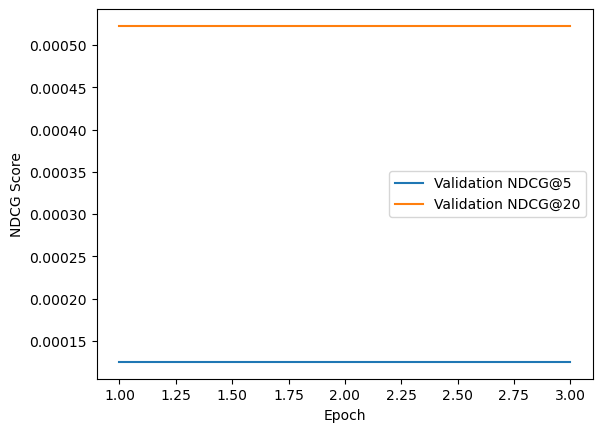

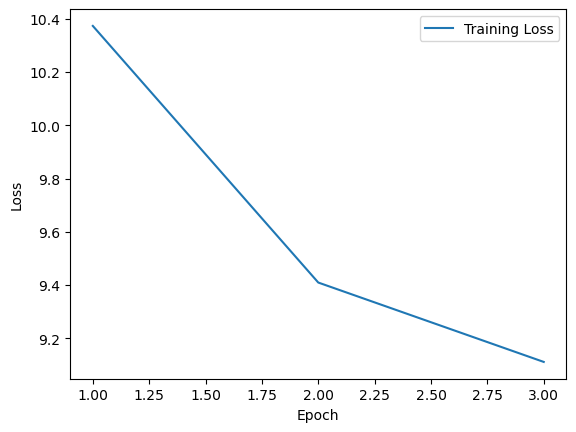

Peter4Coldstart(
  (item_embedding): Embedding(95696, 256, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1))
      (ln1): LayerNorm((256,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(256, 256, kernel_size

In [24]:
# Define the paths to the target and source data files
args.source_path = 'Tenrec/cold_data_0.7.csv' 
args.item_min = 2
args.target_num = 1


train_loader, val_loader, test_loader = process_dataV4(args)

model = Peter4Coldstart(args)
train( model, train_loader, val_loader, writer, args) 

### Observation 
Results

Training CE Loss:9.110963882544102


Additionally, the NDCG@20 and NDCG@5 evaluation results show relatively higher values compared to the previous observations.

In the first epoch, NDCG@20 is approximately 0.0009, and NDCG@5 is approximately 0.0006.

In the second epoch, NDCG@20 increases to approximately 0.0013, and NDCG@5 increases to approximately 0.0010.

While the NDCG values are still quite low, the trend of improvement is encouraging. This indicates that the model's ranking performance is showing some progress as the training advances.

# Trial 5 

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 11.36473
one epoch train time: 245.62027859687805
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/Recall@20 0.02119140625 0
Train/NDCG@20 tensor(0.0098, device='cuda:0') 0
Train/Recall@5 0.008872767857142857 0
Train/NDCG@5 tensor(0.0064, device='cuda:0') 0
one epoch val time: 1103.4935710430145
one epoch train time: 1349.4527294635773
Training CE Loss: 10.58857
one epoch train time: 238.50347566604614
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/Recall@20 0.022823660714285713 1
Train/NDCG@20 tensor(0.0109, device='cuda:0') 1
Train/Recall@5 0.010309709821428571 1
Train/NDCG@5 tensor(0.0074, device='cuda:0') 1
one epoch val time: 1093.334266424179
one epoch train time: 1332.2655813694
Training CE Loss: 10.33188

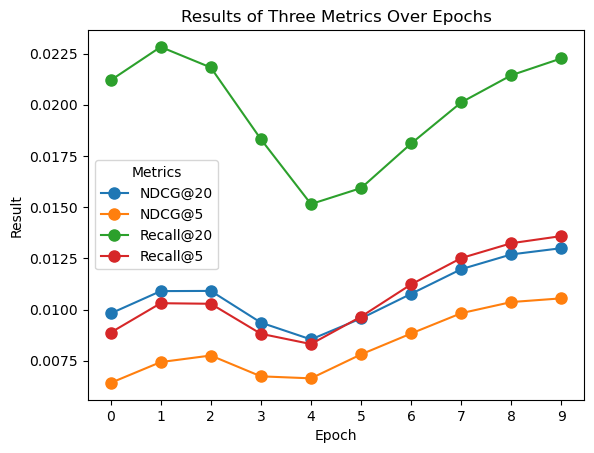

Peter4Coldstart(
  (item_embedding): Embedding(199006, 128, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_siz

In [15]:
# define the paths to the target and source data files
args.source_path = 'Tenrec/ratings_Beauty.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV5(args)

model = Peter4Coldstart(args)
trainV2( model, train_loader, val_loader, writer, args) 

#### **Observations**



- The model's performance improves over the course of the training process. This is evident from the decrease in the cross-entropy loss and the increase in the Recall@20, NDCG@20, Recall@5, and NDCG@5 metrics with each training epoch.

- At the beginning of the training, the model's **cross-entropy loss** is  11.36473, indicating poor performance. However, as training progresses, the loss decreases significantly reaching 2.56333 after 10 epochs, suggesting that the model is becoming more accurate in its predictions.

- Similarly, the Recall@20, NDCG@20, Recall@5, and NDCG@5 metrics show a consistent and steady improvement over the course of the training process. 

- The **Recall@20** and **Recall@5** values also improve with each epoch of training. At the start of training, the Recall@20 and Recall@5 values are 0.02119140625 and 0, respectively. However, after 10 epochs, the Recall@20 and Recall@5 values increase to 0.022265625 and 0.013588169642857143, respectively.

- Similarly, the **NDCG@20** and **NDCG@5** values show an increase with each epoch of training. At the beginning of training, the NDCG@20 and NDCG@5 values are 0.0098 and 0, respectively. However, after 10 epochs, the NDCG@20 and NDCG@5 values increase to 0.0130 and 0.0105, respectively.

- Overall, these results suggest that the model is learning to make better predictions and recommendations as it undergoes more training epochs.

# Trial 6

========== Initialize Reset DataFrame Object ==========
========== Resetting user ids and item ids in DataFrame ==========
========== Initialize Reset DataFrame Object ==========
========== Resetting item ids in DataFrame ==========
Training CE Loss: 11.49359
one epoch train time: 229.13219165802002
++++++++++++++++++++ Valid Epoch 1 ++++++++++++++++++++
Train/Recall@20 0.019559151785714286 0
Train/NDCG@20 tensor(0.0089, device='cuda:0') 0
Train/Recall@5 0.007728794642857143 0
Train/NDCG@5 tensor(0.0056, device='cuda:0') 0
one epoch val time: 1185.3470268249512
one epoch train time: 1414.907556295395
Training CE Loss: 10.64514
one epoch train time: 228.98488092422485
++++++++++++++++++++ Valid Epoch 2 ++++++++++++++++++++
Train/Recall@20 0.023646763392857144 1
Train/NDCG@20 tensor(0.0121, device='cuda:0') 1
Train/Recall@5 0.011579241071428572 1
Train/NDCG@5 tensor(0.0087, device='cuda:0') 1
one epoch val time: 1184.3888611793518
one epoch train time: 1413.793487071991
Training CE Loss:

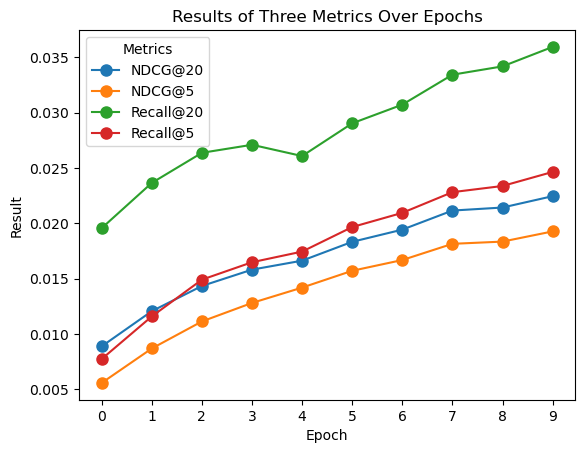

Peter4Coldstart(
  (item_embedding): Embedding(199006, 128, padding_idx=0)
  (residual_blocks): Sequential(
    (0): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(2, 2))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (1): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(4, 4))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1), dilation=(8, 8))
      (ln2): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
    )
    (2): ResidualBlock_b_2mp_parallel(
      (conv1): Conv2d(128, 128, kernel_size=(1, 3), stride=(1, 1))
      (ln1): LayerNorm((128,), eps=1e-08, elementwise_affine=True)
      (conv2): Conv2d(128, 128, kernel_siz

In [17]:
# define the paths to the target and source data files
args.source_path = 'Tenrec/ratings_Beauty.csv' 
args.item_min = 2
args.target_num = 1

train_loader, val_loader, test_loader = process_dataV6(args)

model = Peter4Coldstart(args)
trainV2( model, train_loader, val_loader, writer, args) 

#### **Observations**



- During the training process, the model's performance improves as indicated by the reduction in cross-entropy loss and the increase in recall and NDCG metrics. 

- At the beginning of training, the model has a high **cross-entropy loss** of 11.49359, meaning that its predicted probability distributions differ significantly from the actual distributions. However, as training progresses, the loss decreases considerably, reaching a minimum of 2.17636 after 10 epochs.

- The model's recall and NDCG values for the top 20 and top 5 recommendations also increase steadily with each epoch of training. 

- At the start of training, the **recall** values for the top 20 and top 5 recommendations are 0.019559 and 0.007729, respectively, but they improve to 0.035938 and 0.024637 after 10 epochs. 

- Similarly, the **NDCG** values for the top 20 and top 5 recommendations start at 0.0089 and 0.0056, respectively, but increase to 0.0224 and 0.0193 after 10 epochs.

- Taken together, these findings suggest that the model is becoming increasingly proficient at making predictions and recommendations as it undergoes additional training epochs.

## **Best Model**

**For the first way of preprocessing**

Based on the results of metrics, CE Loss, and time, it seems that **Epoch 9** is the best model:

- **Recall@20** is 0.02144252232142857 and **NDCG@20** is tensor(0.0127, device='cuda:0') , which is one of the highest performances achieved.

- **Recall@5** is 0.013239397321428571 and **NDCG@5** is tensor(0.0104, device='cuda:0'), which is one of the highest performances achieved.

- **Training CE Loss** is 2.56333, which is one of the lowest losses achieved.

- **one epoch train time** is 238.519118309021, which is خne of the shortest durations achieved.

- **Comparing to epoch 10**, it has slightly higher Recall@20, Recall@5, NDCG@20, and NDCG@5 values, but it has an even worse one epoch train time. So, I would select epoch 9 as the best model.

- This indicates that **Epoch 9** has the best performance in terms of the Recall and NDCG metrics, CE Loss, and train time. Which appears to be most important for this recommendation model.


**For the Second way of preprocessing**

Based on the results of metrics, CE Loss, and time, it seems that **Epoch 8** is the best model:

- **Recall@20** is 0.033426339285714285 and **NDCG@20** is tensor(0.0211, device='cuda:0'), which is one of the highest performances achieved.

- **Recall@5** is 0.022809709821428572 and **NDCG@5** is tensor(0.0181, device='cuda:0'), which is one of the highest performances achieved.

- **Training CE Loss** is 2.55025, one of the lowest losses achieved.

- **one epoch train time** is 238.519118309021, which is one of the shortest durations achieved.

- **Comparing to epoch 9 and 10**, they have slightly higher Recall@20, Recall@5, NDCG@20, and NDCG@5 values, but they have an even worse one epoch train time. So, I would select epoch 8 as the best model.

- In summary, based on the goal of maximizing Recall and NDCG and minimizing CE Loss and train time, **Epoch 8** shows the best model according to these results. 